In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *

In [4]:
eta, lamb1, lamb2 = 0.012500, 0.001246, 0.005920
eta_nn, lamb1_nn, lamb2_nn = 0.011057, 0.004059, 0.0

In [14]:
n = 500
g = 8000
k = 20
avgGenesInPath = 50

In [15]:
numReps = 10
intersectionGap = 10
numPlotPoints = int(g / intersectionGap)

def TrainReps(rep, n, g, k):
    #needs: n, g, k
    print('{},'.format(rep), end='')
    intersectionGap = 10
    numPlotPoints = int(g / intersectionGap)

    U, V, binaryPathwayMatrix, genesDrivingPhenotype = GenerateSimulatedData(n, g, k, covariateU=True)
    X = np.dot(U, V.T)
    neighbors = GetNeighborDictionary(binaryPathwayMatrix, percentileThreshold=95)
    
    #Train on all of the data
    U_pred_init, V_pred_init = CreateLatentVariables(n, g, k)
    U_pred, V_pred           = FactorizeMatrix(X, U_pred_init, V_pred_init, neighbors, 
                                     eta=eta, lamb1=lamb1, lamb2=lamb2, num_epochs=10)
    U_pred_nn, V_pred_nn     = FactorizeMatrix(X, U_pred_init, V_pred_init, {}, 
                                     eta=eta_nn, lamb1=lamb1_nn, lamb2=lamb2_nn, num_epochs=10)
    
    tg     = GetTopGenes(V_pred, 0, np.arange(1, g))
    
    tg_nn      = GetTopGenes(V_pred_nn, 0, np.arange(1, g))
    
    tg_true    = GetTopGenes(V, 0, np.arange(1, g)) #Using the ACTUAL latent variables
    
    tg_raw     = GetTopGenes(X.T, 0, np.arange(1, g))
    tg_raw_cor = GetTopGenes(X.T, 0, np.arange(1, g), correlation=True)
    
    intersection_mat = np.zeros((5, numPlotPoints))
    index = 0
    for i in range(0, g, intersectionGap):
        intersection_mat[0, index] = np.sum(np.in1d(tg[i:i+intersectionGap], genesDrivingPhenotype))
        
        intersection_mat[1, index] = np.sum(np.in1d(tg_nn[i:i+intersectionGap], genesDrivingPhenotype))

        intersection_mat[2, index] = np.sum(np.in1d(tg_raw[i:i+intersectionGap], genesDrivingPhenotype))
        intersection_mat[3, index] = np.sum(np.in1d(tg_raw_cor[i:i+intersectionGap], genesDrivingPhenotype))
        
        intersection_mat[4, index] = np.sum(np.in1d(tg_true[i:i+intersectionGap], genesDrivingPhenotype))
        index += 1
    
    return intersection_mat

In [ ]:
numProcesses = 20
p = Pool(numProcesses)
tg_zipped = p.map(partial(TrainReps, n=n, g=g, k=k), range(numReps))
p.close()
p.join()

In [ ]:
im_dot = np.zeros((numReps, numPlotPoints))

nn_dot = np.zeros((numReps, numPlotPoints))

raw_dot = np.zeros((numReps, numPlotPoints))
raw_cor = np.zeros((numReps, numPlotPoints))

true_dot = np.zeros((numReps, numPlotPoints))

for rep in range(numReps):  
    intersection_mat = tg_zipped[rep]
    int_dot = 0
    
    int_nn_dot = 0
    
    int_raw_dot = 0
    int_raw_cor = 0
    
    int_true_dot = 0
    
    for index in range(numPlotPoints):
        int_dot += intersection_mat[0, index]

        int_nn_dot += intersection_mat[1, index]

        int_raw_dot += intersection_mat[2, index]
        int_raw_cor += intersection_mat[3, index]
        
        int_true_dot += intersection_mat[4, index]
        
        im_dot[rep, index] = int_dot
        
        nn_dot[rep, index] = int_nn_dot
        
        raw_dot[rep, index] = int_raw_dot
        raw_cor[rep, index] = int_raw_cor
        
        true_dot[rep, index] = int_true_dot

In [21]:
x_values = np.arange(numPlotPoints) * 10

def MatToMeltDF(im, group_name):
    im_dot_df = pd.DataFrame(im.T)
    im_dot_df['x'] = x_values
    im_dot_df = pd.melt(im_dot_df, id_vars=['x'])
    im_dot_df['group'] = group_name
    return im_dot_df

In [22]:
im_dot_df = MatToMeltDF(im_dot, group_name='MF_dot')

nn_dot_df = MatToMeltDF(nn_dot, group_name='MF_nn_dot')

raw_dot_df = MatToMeltDF(raw_dot, group_name='raw_dot')
raw_cor_df = MatToMeltDF(raw_cor, group_name='raw_cor')

true_dot_df = MatToMeltDF(true_dot, group_name='true_dot')

concat_df = pd.concat([im_dot_df, nn_dot_df, raw_dot_df, raw_cor_df, true_dot_df])
concat_df.head()

,x,variable,value,group
0,0,0,9.0,MF_dot
1,10,0,18.0,MF_dot
2,20,0,25.0,MF_dot
3,30,0,30.0,MF_dot
4,40,0,37.0,MF_dot


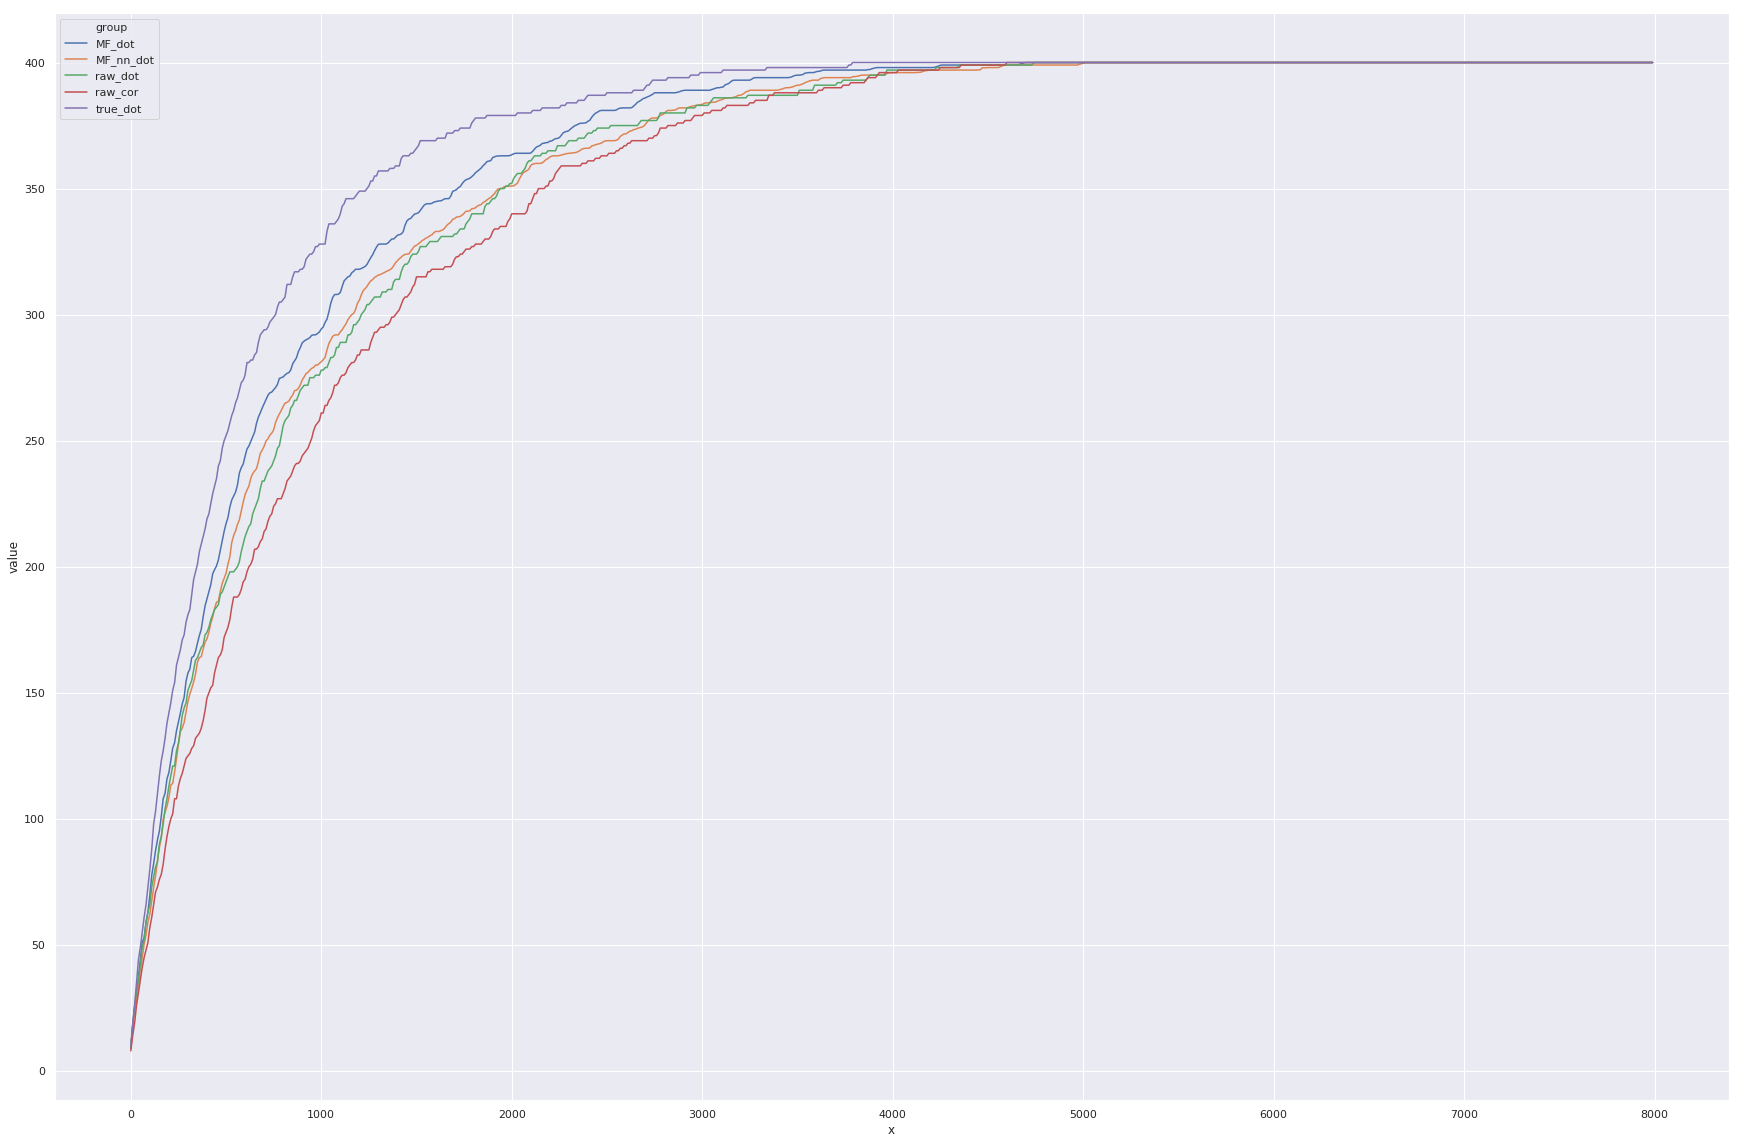

In [23]:
sns.lineplot(x='x', y='value', hue='group', data=concat_df, ci=None)
plt.rcParams['figure.figsize'] = [30, 20]